In [1]:
from vnstock import *
from function import *

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler


In [2]:
ticket = ['CII','CTD','CTG','DHG','DPM','EIB','FPT','GAS','GMD','HDB','HPG','MBB','MSN','MWG','NVL','PNJ','REE','ROS','SAB','SBT','SSI','STB','TCB','VCB','VHM','VIC','VJC','VNM','VPB','VRE']

frame = []
for i in ticket:
    a = stock_historical_data(symbol=i, 
                            start_date="2016-01-01", 
                            end_date='2022-02-25')    
    a["ticker"] = i
    frame.append(a)

close= pd.concat(frame).pivot_table(values="Close", columns="ticker", index="TradingDate")

### Markowitz model

In [14]:
w = marko_weights(close)

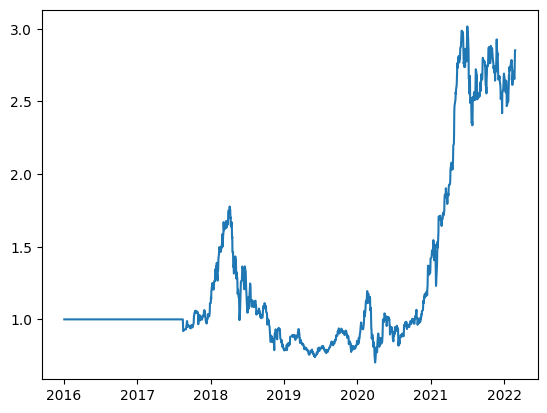

In [15]:
a = Simresult(w,returns=close.pct_change())
plt.plot(a.get_pnl())

### Alpha = ts_delta(close,5) model

In [16]:
lag = 5
close_t5=close-close.shift(lag)

In [17]:
close_t5

ticker,CII,CTD,CTG,DHG,DPM,EIB,FPT,GAS,GMD,HDB,...,SSI,STB,TCB,VCB,VHM,VIC,VJC,VNM,VPB,VRE
TradingDate,,,,,,,,,,,,,,,,,,,,,
2016-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-21,7100.0,2000.0,-200.0,14915.0,2671.0,-1250.0,2040.0,-195.0,2244.0,320.0,...,2168.0,350.0,0.0,1400.0,1846.0,1800.0,6000.0,-95.0,600.0,1100.0
2022-02-22,6400.0,3600.0,-350.0,12397.0,737.0,-2250.0,1470.0,-876.0,3219.0,40.0,...,723.0,200.0,-400.0,-200.0,-680.0,-1700.0,3600.0,-1140.0,-267.0,500.0
2022-02-23,5850.0,4000.0,200.0,12785.0,2119.0,-2800.0,1388.0,2434.0,2634.0,320.0,...,361.0,0.0,100.0,-100.0,-583.0,-400.0,9000.0,-380.0,167.0,600.0


In [18]:
returns = close.pct_change()
w  = weights(close_t5)

In [26]:
class Simresult():
    def __init__(self,weights,returns):
        self.weights = weights
        self.returns = returns

    def get_pnl(self):
        i=np.sum(self.weights*self.returns.shift(-1),axis=1)+1
        a = np.cumprod(i)
        return a

    def get_return(self):
        i=np.sum(self.weights*self.returns.shift(-1),axis=1)+1
        a = np.prod(i)**(252/len(i))-1
        return a

    def get_sharpe(self):
        try:
            return self.get_return()/(np.std(np.sum(self.weights*self.returns.shift(-1),axis=1)+1)*np.sqrt(252))
        except Exception:
            return 0
        
    def get_turnover(self):
        
        weights_t = self.weights.values[1:,:]
        weights_t1 = self.weights.values[:-1,:]
        turnover = np.nansum(np.abs(weights_t - weights_t1), axis = 1)
        return np.mean(turnover)          

    def get_summary(self):
        return pd.DataFrame({'Return': self.get_return(), 
                             'Sharpe': self.get_sharpe(), 
                             'Turnover': self.get_turnover()})
        
    def plot_pnl(self):
        plt.plot(self.get_pnl())
        plt.ylabel("Cummulative return")
        plt.xlabel("Date")
        plt.title("PnL")

In [27]:
kq=Simresult(weights=w,returns=returns)

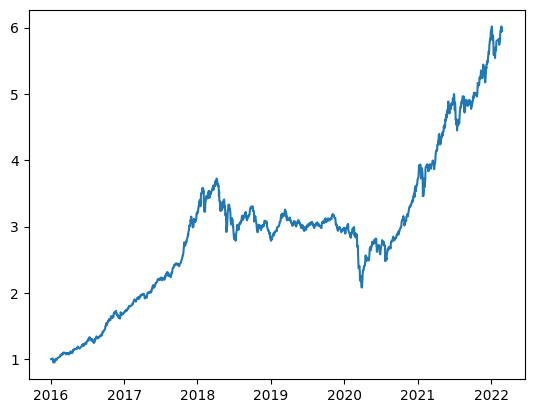

In [28]:
plt.plot(kq.get_pnl())

In [29]:
kq.get_summary()

ValueError: If using all scalar values, you must pass an index